# Feature Selection

This notebook selects the most important features for model training using multiple selection methods.

## What we will do:
1. Load engineered features
2. Correlation analysis and multicollinearity check
3. Feature importance using Random Forest
4. Univariate feature selection
5. L1 regularization (Lasso) feature selection
6. Combine methods and select final features
7. Save selected features


In [46]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


## 1. Load Engineered Features


In [47]:
# Load engineered dataset
df = pd.read_pickle('../../data/processed/df_engineered.pkl')

print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Separate features and target
target = 'SalePrice'
features = [col for col in df.columns if col != target]

print(f"Total features: {len(features)}")
print(f"Target variable: {target}")

# Show data types
print(f"\nData types distribution:")
print(df.dtypes.value_counts())


Dataset shape: (1408, 105)
Missing values: 0
Total features: 104
Target variable: SalePrice

Data types distribution:
int64       35
float64     13
category     7
category     3
category     2
category     2
category     2
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
Name: count, dtype: int64


## 2. Correlation Analysis and Multicollinearity Check


=== CORRELATION ANALYSIS ===
Top 15 features correlated with SalePrice:
Quality_x_TotalSF    0.909622
Quality_x_Area       0.858255
Garage_x_Quality     0.822944
TotalSF              0.814009
GrLivArea            0.704379
Bath_x_Area          0.701452
GarageCars           0.657878
GarageArea           0.645361
TotalBathrooms       0.631732
TotalBsmtSF          0.624685
AvgRoomSize          0.614662
1stFlrSF             0.599719
HouseAge             0.566962
YearBuilt            0.566962
FullBath             0.560519
Name: SalePrice, dtype: float64


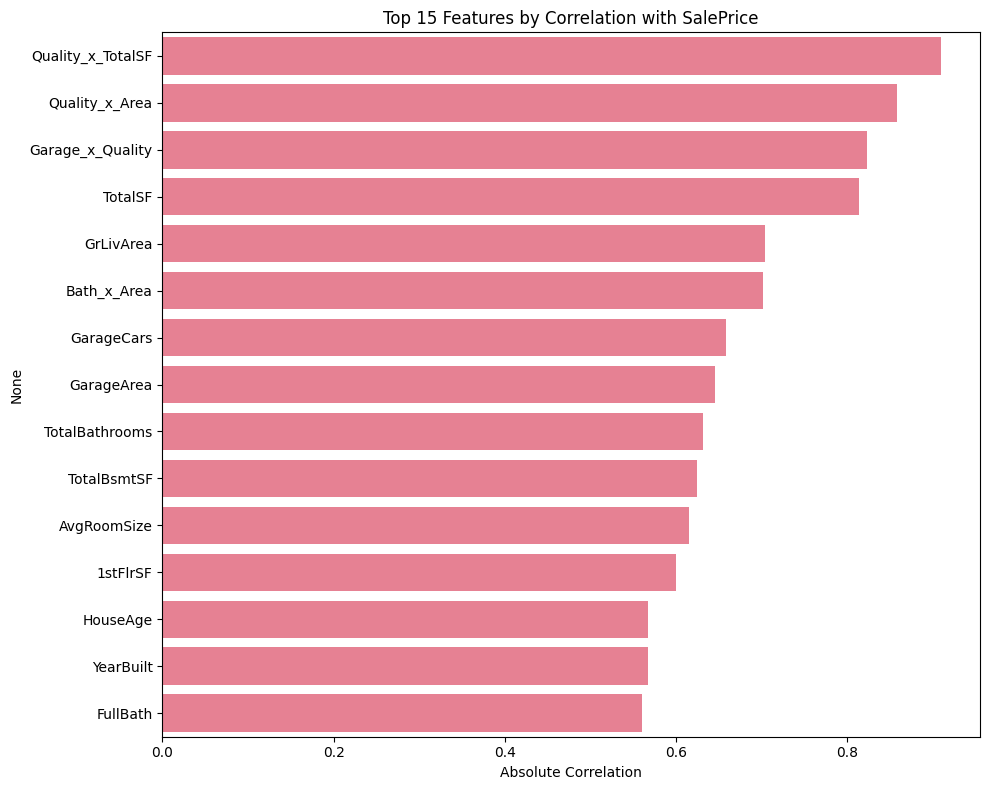


Features with correlation > 0.3: 26
['Quality_x_TotalSF', 'Quality_x_Area', 'Garage_x_Quality', 'TotalSF', 'GrLivArea', 'Bath_x_Area', 'GarageCars', 'GarageArea', 'TotalBathrooms', 'TotalBsmtSF', 'AvgRoomSize', '1stFlrSF', 'HouseAge', 'YearBuilt', 'FullBath', 'EffectiveAge', 'YearRemodAdd', 'TotRmsAbvGrd', 'Fireplaces', 'MasVnrArea', 'LotArea', 'TotalPorchSF', 'BsmtFinSF1', 'LotFrontage', 'OpenPorchSF', 'WoodDeckSF']


In [48]:
# Correlation analysis with target
print("=== CORRELATION ANALYSIS ===")

# Get numeric features only for correlation
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove(target)

# Calculate correlation with target
corr_with_target = df[numeric_features + [target]].corr()[target].abs().sort_values(ascending=False)
corr_with_target = corr_with_target.drop(target)  # Remove self-correlation

print(f"Top 15 features correlated with {target}:")
print(corr_with_target.head(15))

# Visualize top correlations
plt.figure(figsize=(10, 8))
top_corr_features = corr_with_target.head(15)
sns.barplot(x=top_corr_features.values, y=top_corr_features.index)
plt.title('Top 15 Features by Correlation with SalePrice')
plt.xlabel('Absolute Correlation')
plt.tight_layout()
plt.show()

# Select features with correlation > 0.3
high_corr_features = corr_with_target[corr_with_target > 0.3].index.tolist()
print(f"\nFeatures with correlation > 0.3: {len(high_corr_features)}")
print(high_corr_features)


In [49]:
# Check multicollinearity among top features
print("\n=== MULTICOLLINEARITY CHECK ===")

# Select top 20 correlated features for VIF analysis
top_20_features = corr_with_target.head(20).index.tolist()

# Calculate VIF for top features
def calculate_vif(dataframe, features):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(dataframe[features].values, i) 
                       for i in range(len(features))]
    return vif_data.sort_values('VIF', ascending=False)

try:
    vif_df = calculate_vif(df, top_20_features)
    print("VIF values for top 20 correlated features:")
    print(vif_df)
    
    # Features with VIF > 10 indicate multicollinearity
    high_vif = vif_df[vif_df['VIF'] > 10]['Feature'].tolist()
    if high_vif:
        print(f"\nFeatures with high multicollinearity (VIF > 10): {len(high_vif)}")
        print(high_vif)
    else:
        print("\n✓ No severe multicollinearity detected (all VIF < 10)")
        
except Exception as e:
    print(f"VIF calculation error: {e}")
    print("Proceeding without VIF analysis...")
    high_vif = []



=== MULTICOLLINEARITY CHECK ===
VIF values for top 20 correlated features:
              Feature           VIF
13          YearBuilt  2.233851e+06
12           HouseAge  1.393765e+03
4           GrLivArea  3.443863e+02
3             TotalSF  3.236508e+02
0   Quality_x_TotalSF  2.644517e+02
1      Quality_x_Area  2.556291e+02
15       EffectiveAge  2.452626e+02
16       YearRemodAdd  2.446076e+02
9         TotalBsmtSF  8.260046e+01
2    Garage_x_Quality  6.094332e+01
17       TotRmsAbvGrd  4.662225e+01
10        AvgRoomSize  3.407768e+01
5         Bath_x_Area  3.203350e+01
6          GarageCars  3.132352e+01
14           FullBath  6.187867e+00
7          GarageArea  4.954856e+00
11           1stFlrSF  4.546835e+00
8      TotalBathrooms  2.696664e+00
18         Fireplaces  1.393301e+00
19         MasVnrArea  1.329292e+00

Features with high multicollinearity (VIF > 10): 14
['YearBuilt', 'HouseAge', 'GrLivArea', 'TotalSF', 'Quality_x_TotalSF', 'Quality_x_Area', 'EffectiveAge', 'YearRemod

## 3. Feature Importance using Random Forest


=== RANDOM FOREST FEATURE IMPORTANCE ===
Encoded 57 categorical columns for Random Forest
Top 15 features by Random Forest importance:
              feature  importance
81  Quality_x_TotalSF    0.824422
83   Garage_x_Quality    0.010507
91       EffectiveAge    0.009664
34         BsmtFinSF1    0.008051
37          BsmtUnfSF    0.006713
62         GarageArea    0.006607
80     Quality_x_Area    0.006284
53        KitchenQual    0.005733
89            TotalSF    0.005665
90     TotalBathrooms    0.005552
4             LotArea    0.005332
19          YearBuilt    0.004196
88        AvgRoomSize    0.004186
20       YearRemodAdd    0.003887
93           HouseAge    0.003836


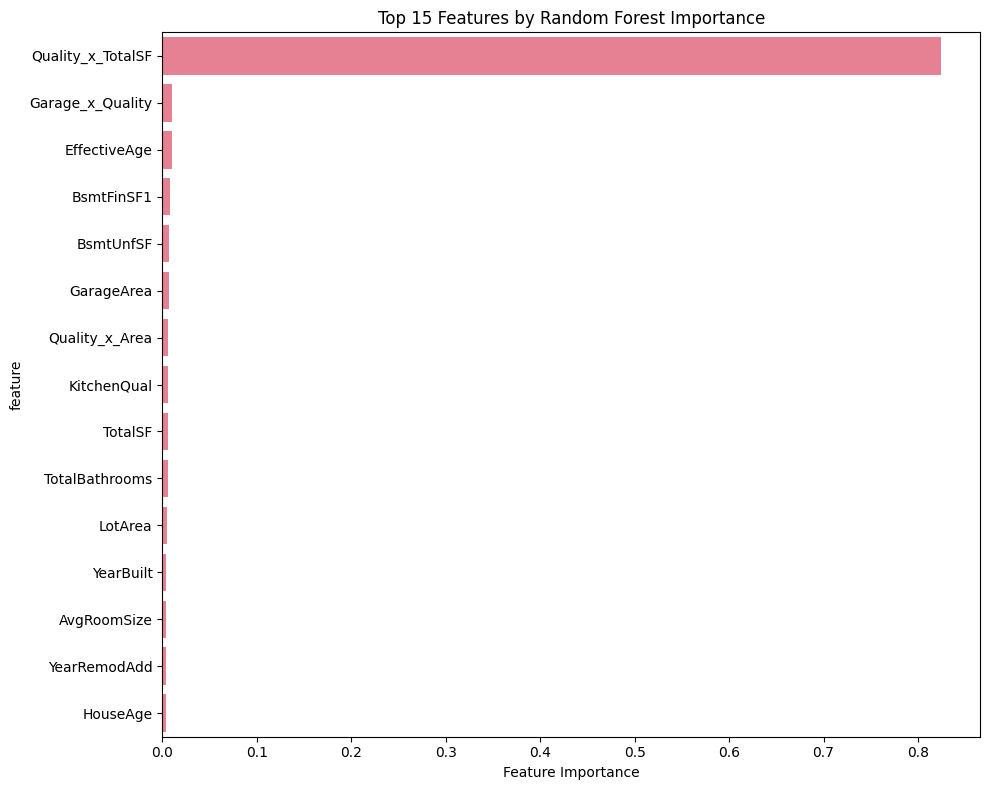


Features with importance > 0.01: 2
['Quality_x_TotalSF', 'Garage_x_Quality']


In [50]:
# Random Forest feature importance
print("=== RANDOM FOREST FEATURE IMPORTANCE ===")

# Prepare data for Random Forest (encode categorical variables)
df_encoded = df.copy()

# Encode categorical variables
categorical_cols = df.select_dtypes(include=['category']).columns.tolist()
le_dict = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

print(f"Encoded {len(categorical_cols)} categorical columns for Random Forest")

# Prepare features and target
X = df_encoded[features]
y = df_encoded[target]

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Get feature importance
rf_importance = pd.DataFrame({
    'feature': features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 features by Random Forest importance:")
print(rf_importance.head(15))

# Visualize feature importance
plt.figure(figsize=(10, 8))
top_rf_features = rf_importance.head(15)
sns.barplot(data=top_rf_features, x='importance', y='feature')
plt.title('Top 15 Features by Random Forest Importance')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# Select top features by importance
rf_top_features = rf_importance[rf_importance['importance'] > 0.01]['feature'].tolist()
print(f"\nFeatures with importance > 0.01: {len(rf_top_features)}")
print(rf_top_features)


## 4. Univariate Feature Selection


=== UNIVARIATE FEATURE SELECTION ===
Top 15 features by F-regression score:
              feature      f_score
34  Quality_x_TotalSF  6740.591798
33     Quality_x_Area  3931.929071
36   Garage_x_Quality  2950.129575
42            TotalSF  2761.288183
13          GrLivArea  1384.509127
35        Bath_x_Area  1361.903666
23         GarageCars  1072.860269
24         GarageArea  1003.557096
43     TotalBathrooms   933.768087
9         TotalBsmtSF   899.793730
41        AvgRoomSize   853.755525
10           1stFlrSF   789.717864
46           HouseAge   666.051635
3           YearBuilt   666.051635
16           FullBath   644.104620


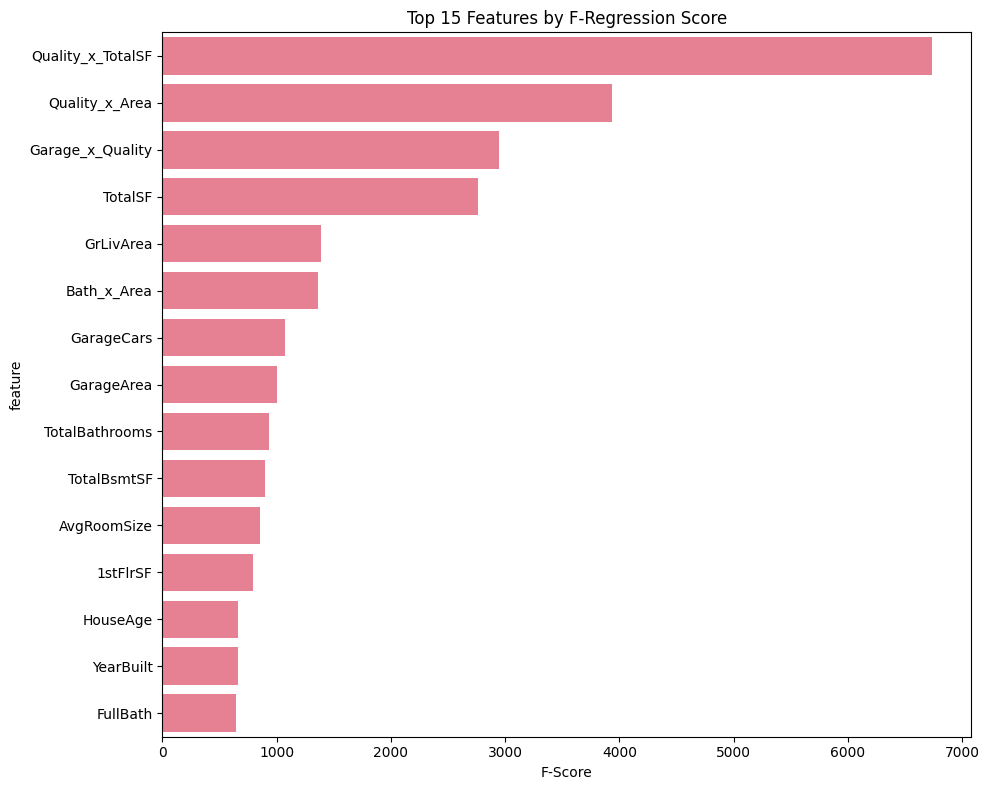


Top 20 features by univariate selection:
['Quality_x_TotalSF', 'Quality_x_Area', 'Garage_x_Quality', 'TotalSF', 'GrLivArea', 'Bath_x_Area', 'GarageCars', 'GarageArea', 'TotalBathrooms', 'TotalBsmtSF', 'AvgRoomSize', '1stFlrSF', 'HouseAge', 'YearBuilt', 'FullBath', 'EffectiveAge', 'YearRemodAdd', 'TotRmsAbvGrd', 'Fireplaces', 'MasVnrArea']


In [51]:
# Univariate feature selection using f_regression
print("=== UNIVARIATE FEATURE SELECTION ===")

# Use only numeric features for f_regression
X_numeric = df_encoded[numeric_features]
y = df_encoded[target]

# Apply SelectKBest with f_regression
k_best = SelectKBest(score_func=f_regression, k='all')
X_selected = k_best.fit_transform(X_numeric, y)

# Get f-scores
f_scores = pd.DataFrame({
    'feature': numeric_features,
    'f_score': k_best.scores_
}).sort_values('f_score', ascending=False)

print("Top 15 features by F-regression score:")
print(f_scores.head(15))

# Visualize F-scores
plt.figure(figsize=(10, 8))
top_f_features = f_scores.head(15)
sns.barplot(data=top_f_features, x='f_score', y='feature')
plt.title('Top 15 Features by F-Regression Score')
plt.xlabel('F-Score')
plt.tight_layout()
plt.show()

# Select features with high F-scores (top 20)
univariate_top_features = f_scores.head(20)['feature'].tolist()
print(f"\nTop 20 features by univariate selection:")
print(univariate_top_features)


## 5. L1 Regularization (Lasso) Feature Selection


=== LASSO FEATURE SELECTION ===
Optimal alpha: 192.015117
Features selected by Lasso: 78

Top 15 features by Lasso coefficient magnitude:
                  feature   coefficient  abs_coefficient
81      Quality_x_TotalSF  28030.313246     28030.313246
46              GrLivArea   9631.059839      9631.059839
83       Garage_x_Quality   6752.091187      6752.091187
103  NeighborhoodCategory   5718.033089      5718.033089
18            OverallCond   5653.334704      5653.334704
34             BsmtFinSF1   5319.612953      5319.612953
19              YearBuilt   5028.356431      5028.356431
102       QualityCategory  -4594.079308      4594.079308
4                 LotArea   3369.767418      3369.767418
71               PoolArea   3332.617934      3332.617934
53            KitchenQual  -3131.560414      3131.560414
52           KitchenAbvGr  -3106.748831      3106.748831
82            Bath_x_Area   3095.078172      3095.078172
79          SaleCondition   3090.374630      3090.374630
92     

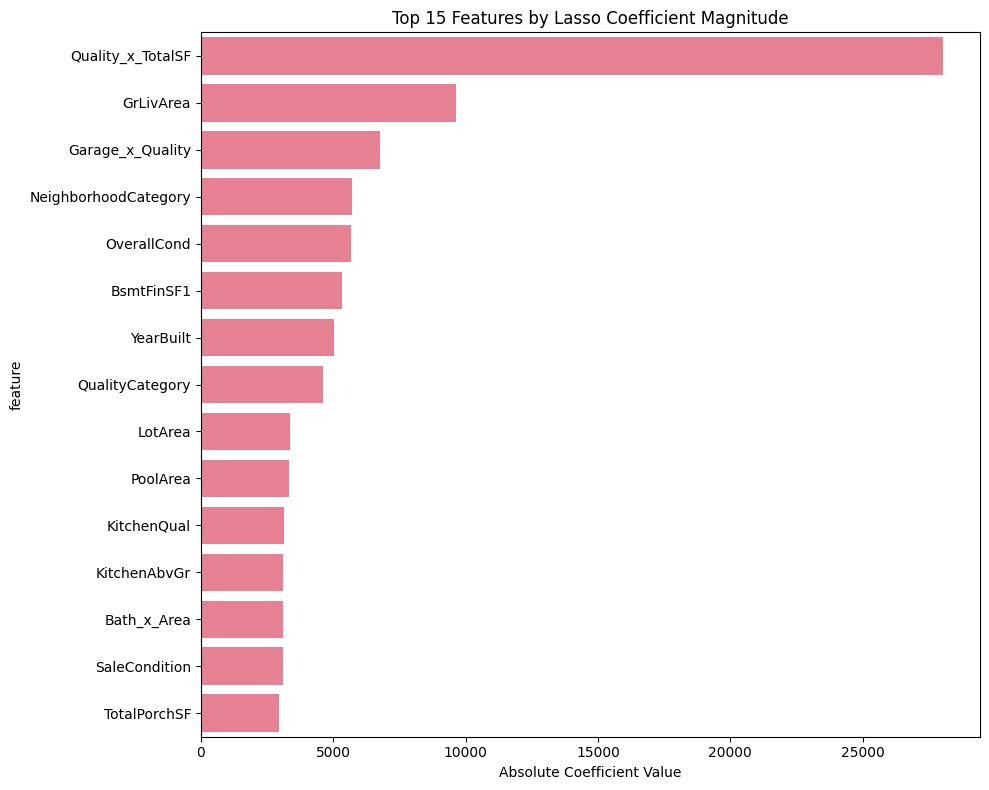


Lasso selected features: 78
['Quality_x_TotalSF', 'GrLivArea', 'Garage_x_Quality', 'NeighborhoodCategory', 'OverallCond', 'BsmtFinSF1', 'YearBuilt', 'QualityCategory', 'LotArea', 'PoolArea', 'KitchenQual', 'KitchenAbvGr', 'Bath_x_Area', 'SaleCondition', 'TotalPorchSF', 'Functional', 'PoolQC', 'ExterQual', 'BsmtUnfSF', 'EffectiveAge', 'IsNew', 'OverallQual', 'BsmtFullBath', 'MasVnrArea', 'BsmtQual', 'BedroomAbvGr', 'Fireplaces', 'GrLivArea_to_LotArea', 'HouseAge', 'BldgType', 'HasPorch', 'RoofMatl', 'MasVnrType', 'Exterior1st', 'AgeCategory', 'FireplaceQu', 'BsmtCond', 'Neighborhood', 'TotRmsAbvGrd', 'HasBasement', 'ScreenPorch', 'Street', 'BsmtExposure', 'GarageFinish', 'HeatingQC', 'Id', 'GarageArea', 'GarageType', 'Utilities', 'Exterior2nd', 'LowQualFinSF', 'Foundation', 'LandSlope', 'Alley', 'CentralAir', 'Heating', 'SaleType', 'MSSubClass', 'MoSold', 'HasFireplace', 'ExterCond', 'Condition2', 'FullBath', 'YrSold', 'MiscFeature', 'LotConfig', 'EnclosedPorch', 'OpenPorchSF', 'HalfBa

In [52]:
# Lasso feature selection
print("=== LASSO FEATURE SELECTION ===")

# Scale features for Lasso
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use LassoCV to find optimal alpha
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=2000)
lasso_cv.fit(X_scaled, y)

print(f"Optimal alpha: {lasso_cv.alpha_:.6f}")

# Train Lasso with optimal alpha
lasso = Lasso(alpha=lasso_cv.alpha_, max_iter=2000)
lasso.fit(X_scaled, y)

# Get Lasso coefficients
lasso_coefs = pd.DataFrame({
    'feature': features,
    'coefficient': lasso.coef_
})

# Select features with non-zero coefficients
lasso_selected = lasso_coefs[lasso_coefs['coefficient'] != 0].copy()
lasso_selected['abs_coefficient'] = abs(lasso_selected['coefficient'])
lasso_selected = lasso_selected.sort_values('abs_coefficient', ascending=False)

print(f"Features selected by Lasso: {len(lasso_selected)}")
print("\nTop 15 features by Lasso coefficient magnitude:")
print(lasso_selected.head(15))

# Visualize Lasso coefficients
plt.figure(figsize=(10, 8))
top_lasso = lasso_selected.head(15)
sns.barplot(data=top_lasso, x='abs_coefficient', y='feature')
plt.title('Top 15 Features by Lasso Coefficient Magnitude')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()

lasso_features = lasso_selected['feature'].tolist()
print(f"\nLasso selected features: {len(lasso_features)}")
print(lasso_features)


## 6. Combine Methods and Select Final Features


In [53]:
# Combine all selection methods
print("=== COMBINING FEATURE SELECTION METHODS ===")

# Create a voting system
all_feature_lists = {
    'High_Correlation': high_corr_features,
    'Random_Forest': rf_top_features,
    'Univariate': univariate_top_features,
    'Lasso': lasso_features
}

# Count votes for each feature
feature_votes = {}
for method, feature_list in all_feature_lists.items():
    print(f"{method}: {len(feature_list)} features")
    for feature in feature_list:
        if feature in feature_votes:
            feature_votes[feature] += 1
        else:
            feature_votes[feature] = 1

# Create voting results DataFrame
voting_results = pd.DataFrame([
    {'feature': feature, 'votes': votes} 
    for feature, votes in feature_votes.items()
]).sort_values('votes', ascending=False)

print(f"\nFeature voting results:")
print(voting_results.head(20))

# Select features with at least 2 votes
final_features = voting_results[voting_results['votes'] >= 2]['feature'].tolist()

# Ensure we have a reasonable number of features (15-25)
if len(final_features) > 25:
    final_features = voting_results.head(25)['feature'].tolist()
elif len(final_features) < 15:
    final_features = voting_results.head(15)['feature'].tolist()

print(f"\n=== FINAL FEATURE SELECTION ===")
print(f"Features selected: {len(final_features)}")
print("Final feature list:")
for i, feature in enumerate(final_features, 1):
    votes = voting_results[voting_results['feature'] == feature]['votes'].iloc[0]
    print(f"  {i:2d}. {feature} (votes: {votes})")

# Add categorical features that might be important
important_categorical = [col for col in categorical_cols if col in final_features]
if important_categorical:
    print(f"\nCategorical features included: {len(important_categorical)}")
    print(important_categorical)


=== COMBINING FEATURE SELECTION METHODS ===
High_Correlation: 26 features
Random_Forest: 2 features
Univariate: 20 features
Lasso: 78 features

Feature voting results:
              feature  votes
0   Quality_x_TotalSF      4
2    Garage_x_Quality      4
5         Bath_x_Area      3
4           GrLivArea      3
7          GarageArea      3
13          YearBuilt      3
14           FullBath      3
15       EffectiveAge      3
18         Fireplaces      3
19         MasVnrArea      3
17       TotRmsAbvGrd      3
12           HouseAge      3
6          GarageCars      2
3             TotalSF      2
1      Quality_x_Area      2
11           1stFlrSF      2
8      TotalBathrooms      2
9         TotalBsmtSF      2
10        AvgRoomSize      2
16       YearRemodAdd      2

=== FINAL FEATURE SELECTION ===
Features selected: 24
Final feature list:
   1. Quality_x_TotalSF (votes: 4)
   2. Garage_x_Quality (votes: 4)
   3. Bath_x_Area (votes: 3)
   4. GrLivArea (votes: 3)
   5. GarageArea (votes

## 7. Save Selected Features


In [54]:
# Create final dataset with selected features
print("=== SAVING SELECTED FEATURES ===")

# Create dataset with selected features + target
selected_columns = final_features + [target]
df_selected = df[selected_columns].copy()

print(f"Selected dataset shape: {df_selected.shape}")
print(f"Features: {len(final_features)}")
print(f"Target: {target}")

# Validate dataset
print(f"\nDataset validation:")
print(f"Missing values: {df_selected.isnull().sum().sum()}")
print(f"Infinite values: {np.isinf(df_selected.select_dtypes(include=[np.number])).sum().sum()}")

# Show data types
print(f"\nData types in selected dataset:")
dtype_counts = df_selected.dtypes.value_counts()
print(dtype_counts)

# Save selected features dataset
import os
processed_dir = '../../data/processed/'
os.makedirs(processed_dir, exist_ok=True)

output_file = os.path.join(processed_dir, 'df_selected_features.pkl')
df_selected.to_pickle(output_file)

print(f"\n✓ Selected features dataset saved to: {output_file}")
print(f"File size: {os.path.getsize(output_file) / 1024**2:.2f} MB")

# Display sample of selected dataset
print(f"\nSample of selected features dataset:")
print(df_selected.head())

# Save feature selection summary
summary = {
    'total_original_features': len(features),
    'total_selected_features': len(final_features),
    'selection_methods_used': list(all_feature_lists.keys()),
    'final_features': final_features,
    'categorical_features': important_categorical,
    'target_variable': target
}

# Save summary as text file
summary_file = os.path.join(processed_dir, 'feature_selection_summary.txt')
with open(summary_file, 'w') as f:
    f.write("=== FEATURE SELECTION SUMMARY ===\n\n")
    f.write(f"Original features: {summary['total_original_features']}\n")
    f.write(f"Selected features: {summary['total_selected_features']}\n")
    f.write(f"Selection methods: {', '.join(summary['selection_methods_used'])}\n\n")
    f.write("Selected features:\n")
    for i, feature in enumerate(summary['final_features'], 1):
        f.write(f"  {i:2d}. {feature}\n")

print(f"✓ Feature selection summary saved to: {summary_file}")


=== SAVING SELECTED FEATURES ===
Selected dataset shape: (1408, 25)
Features: 24
Target: SalePrice

Dataset validation:
Missing values: 0
Infinite values: 0

Data types in selected dataset:
int64      18
float64     7
Name: count, dtype: int64

✓ Selected features dataset saved to: ../../data/processed/df_selected_features.pkl
File size: 0.28 MB

Sample of selected features dataset:
   Quality_x_TotalSF  Garage_x_Quality  Bath_x_Area  GrLivArea  GarageArea  \
0            17962.0              14.0       4275.0       1710         548   
1            15144.0              12.0       2524.0       1262         460   
2            18942.0              14.0       4465.0       1786         608   
3            17311.0              21.0       1717.0       1717         642   
4            26744.0              24.0       5495.0       2198         836   

   YearBuilt  FullBath  EffectiveAge  Fireplaces  MasVnrArea  TotRmsAbvGrd  \
0       2003         2             5           0       196.0       